<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC4</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Series temporales y combinación de modelos de clasificación

Está práctica está dividida en dos partes:

 - En el primer ejercicio veremos cómo descomponer y componer series temporales para realizar predicciones a futuro. 
 - En el segundo ejercicio estudiaremos diferentes técnicas mediante las que podremos combinar el resultado de múltiples clasificadores.

Para esta PEC se deben usar **únicamente las librerías que se importan a continuación**. Si se desea usar otra librería hay que consultarlo con el tutor/tutora del aula.

**Importante: cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato HTML donde se vea el código, los resultados y los comentarios de cada ejercicio. Para exportar el notebook a HTML puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong> Angel Bujalance Gomez
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

# 1. Series temporales (6 puntos)

En este primer ejercicio trabajaremos las series temporales. Para ello, usaremos el dataset *AirPassangers* que contiene información del número de vuelos que se realizaron a lo largo de muchos años.

Empezaremos leyendo los datos y observando gráficamente su distribución. Como se puede apreciar es un claro caso de serie temporal, con heterocedasticidad, tendencia, periodo y ruido. A lo largo de este ejercicio trataremos cada uno de estos puntos.

In [2]:
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', header=0)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

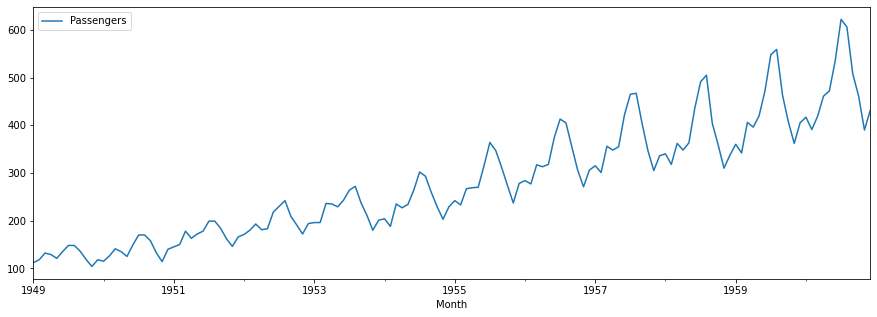

In [3]:
data.plot(figsize=(15, 5))

Antes de empezar a tratar las diferentes componenetes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.

In [4]:
TEST_SIZE = 24
train, test = data.iloc[:-TEST_SIZE].to_numpy(), data.iloc[-TEST_SIZE:].to_numpy()
x_train, x_test = np.arange(train.shape[0]), np.arange(train.shape[0], data.shape[0])
train.shape, x_train.shape, test.shape, x_test.shape

((120, 1), (120,), (24, 1), (24,))

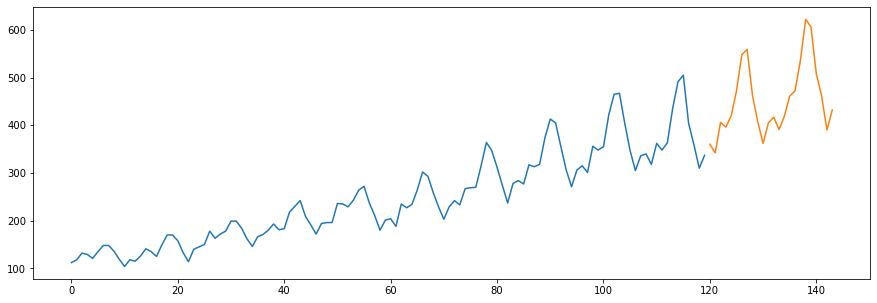

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

## 1.1 Componentes de la serie temporal

### 1.1.a. Heterocedasticidad

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad). En nuestro caso, observamos que tenemos heterocedasticidad, ya que la amplitud de onda varía con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> transforma los datos para eliminar la heterocedasticidad. Para ello debéis transformar los datos aplicando la función que consideréis que elimina mejor la heterocedasticidad en el dataset (exponencial, logarítmica, ...). Estas funciones ya están implementadas en numpy. Graficar los datos originales junto con los datos transformados.
</div>

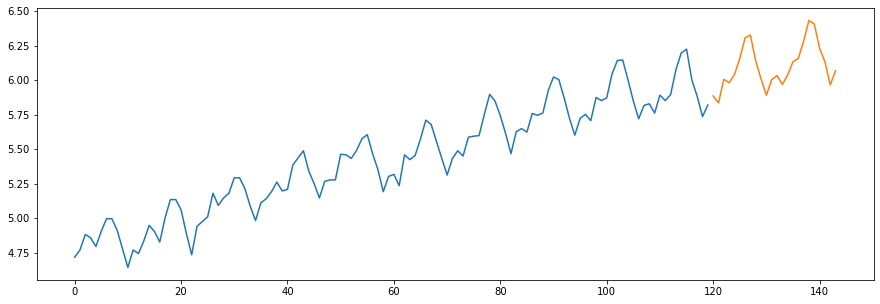

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, np.log(train))
ax.plot(x_test, np.log(test))

Como se describe en el enlace de Wikipedia en inglés (https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity#Correcting_for_heteroscedasticity), una de las maneras de corregir la heterocedasticidad es aplicar una transformación logarítmica a los datos. La escala logarítmica sirve para compactar un rango de números en una escala más pequeña. De hecho, se usa para transformar datos que crecen de forma exponencial para que estén en la misma escala (https://en.wikipedia.org/wiki/Logarithmic_scale). Justo es el caso en el que nos encontrábamos, el valor de los ciclos estaba creciendo exponencialmente de un ciclo al siguiente. De manera que después de aplicar la transformación logarítmica, la heterocedasticidad se ha reducido.

### 1.1.b. Tendencia

La tendencia es el comportamento que tienen los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una tendencia lineal creciente. En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> elimina la tendencia de los datos. Observando la serie podemos apreciar que tenemos una tendencia lineal, por ese motivo podemos ajustar una regresión lineal (usando scikit-learn) y sustraerla a los datos originales (sin heterocedasticidad). Graficar los datos con tendencia junto con los datos sin tendencia.
</div>

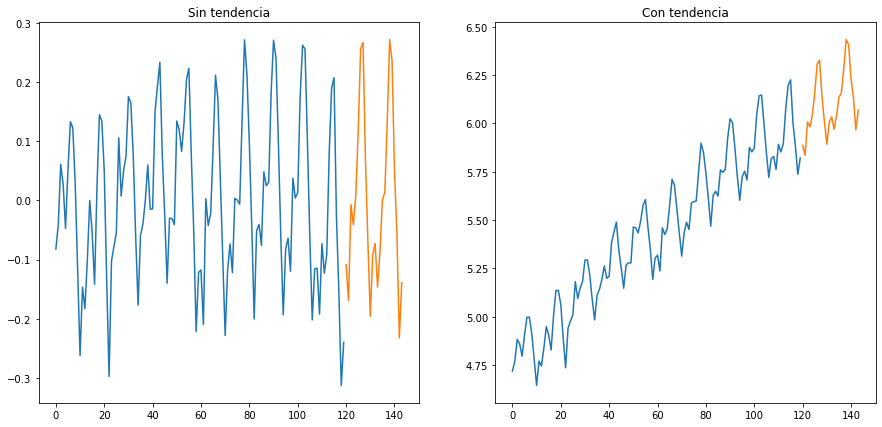

In [349]:
# guardo las dos transformaciones logarítmicas
train_homo = np.log(train)
test_homo = np.log(test)


# Damos una nueva forma a los datos para calcular la regression
x_train_rshape = x_train.reshape(-1,1)
train_ho_rs = train_homo.reshape(-1,1)

x_test_rshape = x_test.reshape(-1,1)
test_ho_rs = test_homo.reshape(-1,1)


# calcualmos una regresión para calcular la tendencia central de los datos
train_tend = LinearRegression().fit(x_train_rshape, train_ho_rs).predict(x_train_rshape)
test_tend = LinearRegression().fit(x_test_rshape, test_ho_rs).predict(x_test_rshape)


# elimino la tendencia mediante una regresión lineal
train_hrt = train_ho_rs - train_tend
test_hrt = test_ho_rs - test_tend


# grafico los datos con tendencia y sin tendencia de los datos de entrenamiento y test
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(x_train, train_hrt)
ax[0].plot(x_test, test_hrt)
ax[0].set_title('Sin tendencia')

ax[1].plot(x_train, train_ho_rs)
ax[1].plot(x_test, test_ho_rs)
ax[1].set_title('Con tendencia')

plt.show()

### 1.1.c. Estacionalidad

Definimos la estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad). En este apartado se debe encontrar y eliminar la estacionalidad. 

#### 1.1.c.a. Encontrar el periodo de la estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> en primer lugar debeis encontrar el ciclo, es decir, cada cuánto se repiten los datos. Para ello podemos usar la autocorrelación (numpy te permite obtener los coeficientes de correlación). Graficar los coeficientes para los 22 primeros valores de autocorrelación y determinar su valor máximo, está será nuestra estacionalidad. Dar una interpretación semántica del resultado obtenido.
</div>

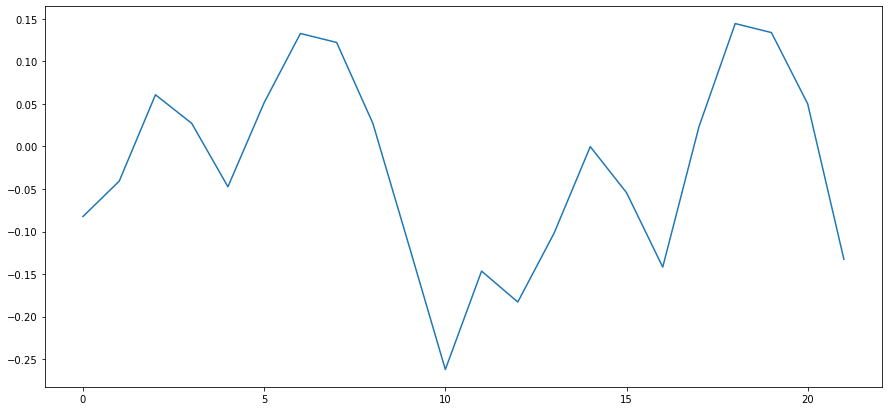

In [102]:

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(x_train[:22], train_hrt[:22])

In [111]:
arr = train_hrt[:22].flatten()

autocorr_arr = np.correlate(arr, arr, mode='full')
autocorr_arr

array([ 0.01092218,  0.00127282, -0.02113817, -0.01791724,  0.0079949 ,
        0.01395157, -0.00579625, -0.01526581,  0.02792968,  0.0781044 ,
        0.06189215, -0.01058139, -0.04780132, -0.08041004, -0.0832689 ,
       -0.04217624, -0.02198744, -0.02584702, -0.02181908,  0.03108581,
        0.16381527,  0.28144953,  0.16381527,  0.03108581, -0.02181908,
       -0.02584702, -0.02198744, -0.04217624, -0.0832689 , -0.08041004,
       -0.04780132, -0.01058139,  0.06189215,  0.0781044 ,  0.02792968,
       -0.01526581, -0.00579625,  0.01395157,  0.0079949 , -0.01791724,
       -0.02113817,  0.00127282,  0.01092218])

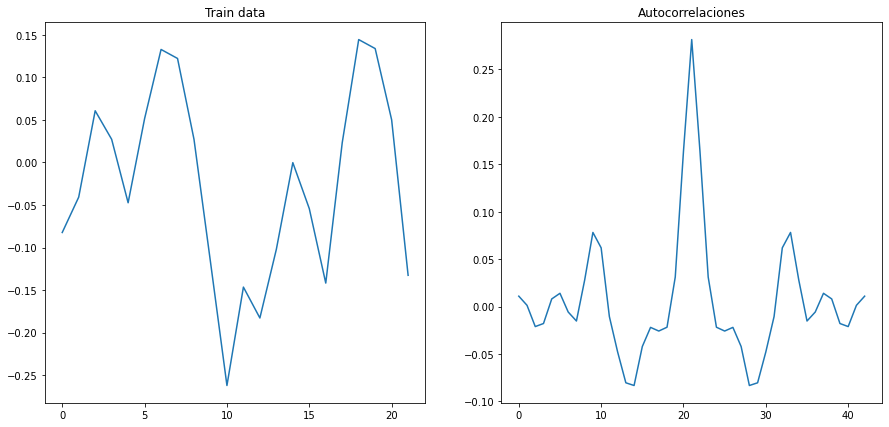

In [113]:
x_autocorr = range(0, len(autocorr_arr))

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(x_train[:22], train_hrt[:22])
ax[0].set_title('Train data')
ax[1].plot(x_autocorr, autocorr_arr)
ax[1].set_title('Autocorrelaciones')
plt.show()

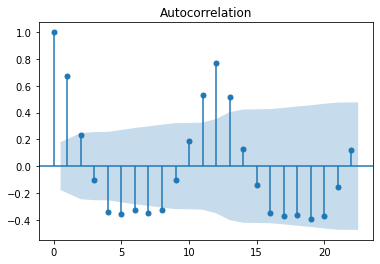

In [119]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(train_hrt, lags=22)

plt.show()

In [148]:
autocorr = sm.tsa.stattools.acf(x=train_hrt, nlags=22, fft=True)[1:]

cycle_len = 1
for i in autocorr:
    if i < autocorr.max():
       cycle_len += 1
    else:
        break
print('El ciclo dura:',cycle_len)

El ciclo dura: 12


#### 1.1.c.b. Calcular el patron de estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> ahora que ya conocéis el ciclo, debéis calcular el patrón (el molde de la estacionalidad). Es decir, para cada punto, calcular la mediana de ese punto en cada uno de los ciclos de la serie. 
</div>

In [227]:
nciclos = len(train_hrt)/cycle_len
print(nciclos)

def create_cycle(x: np.array, t: int, tlag: int) -> np.array:
    """Returns a cycle with the desired length."""
    return x[t:t+tlag]

def array_to_cycles(x: np.array, cycles: int) -> pd.DataFrame:
    """Breaks an array into a pd.DataFrame where each column corresponds to a cycle."""

    t = np.linspace(0, len(x), cycles+1).astype(int)

    data = {"Cycle " + str(int(ti)+1): x[t[ti]:t[ti+1]].tolist() for ti in range(0, len(t)-1)}

    return pd.DataFrame.from_dict(data)


10.0


In [241]:
tr_cycle_df = array_to_cycles(train_hrt[:,0], int(nciclos))
tr_cycle_df.head()

,Cycle 1,Cycle 2,Cycle 3,Cycle 4,Cycle 5,Cycle 6,Cycle 7,Cycle 8,Cycle 9,Cycle 10
0,-0.082329,-0.182859,-0.078020,-0.040054,-0.030565,-0.117523,-0.073668,-0.040595,-0.063959,-0.114549
1,-0.040724,-0.102090,-0.054699,0.000659,-0.041146,-0.209781,-0.122148,-0.076132,-0.120002,-0.192024
2,0.060813,-0.000192,0.105869,0.059813,0.133991,0.002782,0.003482,0.048172,0.037238,-0.073011
3,0.027243,-0.054257,0.007255,-0.014961,0.119165,-0.042434,0.000365,0.024894,0.003930,-0.123033
4,-0.047359,-0.141799,0.050419,-0.014552,0.082721,-0.022643,-0.006505,0.030162,0.013265,-0.091413


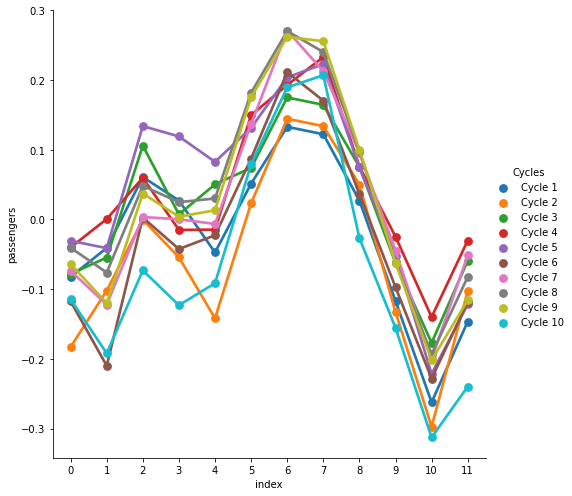

In [243]:
tr_cycle_dfm = tr_cycle_df.reset_index().melt('index', var_name='Cycles', value_name='passengers')

import seaborn as sns

# representación gráfica de los diferentes ciclos en un único plot
sns.catplot(x='index', y='passengers', hue='Cycles', data=tr_cycle_dfm, kind='point', height=7)
plt.show()

Ahora que ya he obtenido los diferentes ciclos y los he guardado en un dataframe, el siguiente paso es calcular la mediana para cada punto de la serie. Es decir, para cada medida que se ha tomado en cada ciclo, calcularé la mediana de estos puntos. Para eso, obtendré la matriz traspuesta de la matriz de ciclos recién calculada y obtendré la mediana de las columnas. Como el número de ciclos es par, la mediana será la media entre los dos valores intermedios. Es decir, de aquellos dos valores que tras ordenar los datos se encuentran en el centro.

In [248]:
tr_cycle_dfT = tr_cycle_df.T
tr_cycle_dfT

,0,1,2,3,4,5,6,7,8,9,10,11
Cycle 1,-0.082329,-0.040724,0.060813,0.027243,-0.047359,0.051545,0.132902,0.122322,0.027185,-0.116927,-0.262240,-0.146526
Cycle 2,-0.182859,-0.102090,-0.000192,-0.054257,-0.141799,0.023254,0.144526,0.133945,0.050162,-0.132664,-0.297395,-0.102532
Cycle 3,-0.078020,-0.054699,0.105869,0.007255,0.050419,0.074128,0.175069,0.164489,0.075540,-0.062380,-0.176950,-0.059149
Cycle 4,-0.040054,0.000659,0.059813,-0.014961,-0.014552,0.149877,0.192881,0.233159,0.075975,-0.024666,-0.140025,-0.030242
Cycle 5,-0.030565,-0.041146,0.133991,0.119165,0.082721,0.131480,0.203788,0.223060,0.074738,-0.052044,-0.221526,-0.121758
Cycle 6,-0.117523,-0.209781,0.002782,-0.042434,-0.022643,0.087405,0.211303,0.170468,0.036543,-0.097143,-0.228239,-0.118304
Cycle 7,-0.073668,-0.122148,0.003482,0.000365,-0.006505,0.137065,0.271066,0.212657,0.095755,-0.044700,-0.200348,-0.051368
Cycle 8,-0.040595,-0.076132,0.048172,0.024894,0.030162,0.181786,0.270397,0.240256,0.097907,-0.061206,-0.193252,-0.082366
Cycle 9,-0.063959,-0.120002,0.037238,0.003930,0.013265,0.175572,0.262024,0.255736,0.100241,-0.062429,-0.202022,-0.115803
Cycle 10,-0.114549,-0.192024,-0.073011,-0.123033,-0.091413,0.078950,0.189468,0.207002,-0.026722,-0.155395,-0.312725,-0.239794


In [262]:
tr_cycle_median = tr_cycle_dfT.median().reset_index()
tr_cycle_median

,index,0
0,0,-0.075844
1,1,-0.089111
2,2,0.042705
3,3,0.002147
4,4,-0.010528
5,5,0.109443
6,6,0.198334
7,7,0.209830
8,8,0.075139
9,9,-0.062405


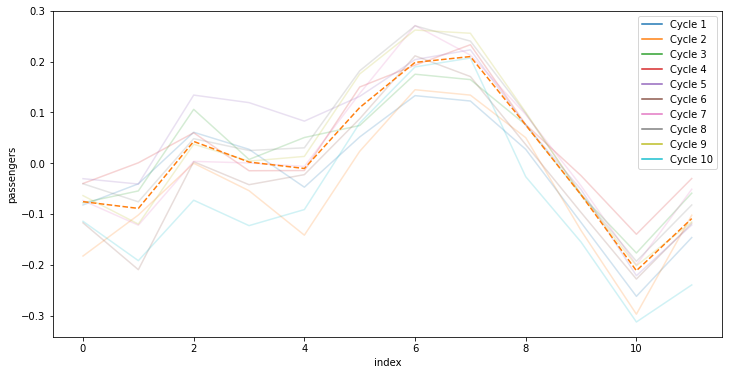

In [266]:
plt.figure(figsize=(12,6))
sns.lineplot(x='index', y='passengers', hue='Cycles', data=tr_cycle_dfm, alpha=.2)
sns.lineplot(x='index', y=0, data=tr_cycle_median, ls='--')
plt.show()

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> una vez obtenido el patrón, replicadlo a lo largo de toda la serie temporal. Cuando lo hayáis calculado debéis restarlo de la serie temporal (sin tendencia ni heterocedasticidad). Graficar los datos con estacionalidad junto con los datos sin estacionalidad.
</div>

In [270]:
tr_cycle_dfT_cl = tr_cycle_dfT - tr_cycle_median[0]
tr_cycle_df_cl = tr_cycle_dfT_cl.T
tr_cycle_df_cl

,Cycle 1,Cycle 2,Cycle 3,Cycle 4,Cycle 5,Cycle 6,Cycle 7,Cycle 8,Cycle 9,Cycle 10
0,-0.006485,-0.107015,-0.002176,0.035791,0.045279,-0.041679,0.002176,0.035250,0.011885,-0.038705
1,0.048387,-0.012979,0.034411,0.089770,0.047965,-0.120671,-0.033037,0.012979,-0.030891,-0.102913
2,0.018108,-0.042897,0.063163,0.017107,0.091286,-0.039923,-0.039223,0.005467,-0.005467,-0.115716
3,0.025096,-0.056405,0.005108,-0.017108,0.117017,-0.044581,-0.001783,0.022746,0.001783,-0.125180
4,-0.036830,-0.131270,0.060948,-0.004024,0.093249,-0.012114,0.004024,0.040690,0.023793,-0.080884
5,-0.057897,-0.086189,-0.035314,0.040434,0.022038,-0.022038,0.027623,0.072343,0.066130,-0.030492
6,-0.065432,-0.053808,-0.023265,-0.005453,0.005453,0.012968,0.072732,0.072063,0.063690,-0.008866
7,-0.087507,-0.075884,-0.045341,0.023329,0.013231,-0.039362,0.002828,0.030427,0.045906,-0.002828
8,-0.047954,-0.024977,0.000401,0.000836,-0.000401,-0.038596,0.020616,0.022768,0.025102,-0.101861
9,-0.054522,-0.070260,0.000025,0.037739,0.010361,-0.034739,0.017705,0.001199,-0.000025,-0.092990


In [277]:
tr_cycle_df_clm = tr_cycle_dfT_cl.T.reset_index().melt('index', var_name='Cycles', value_name='passengers')
tr_cycle_df_clm.head()

,index,Cycles,passengers
0,0,Cycle 1,-0.006485
1,1,Cycle 1,0.048387
2,2,Cycle 1,0.018108
3,3,Cycle 1,0.025096
4,4,Cycle 1,-0.036830


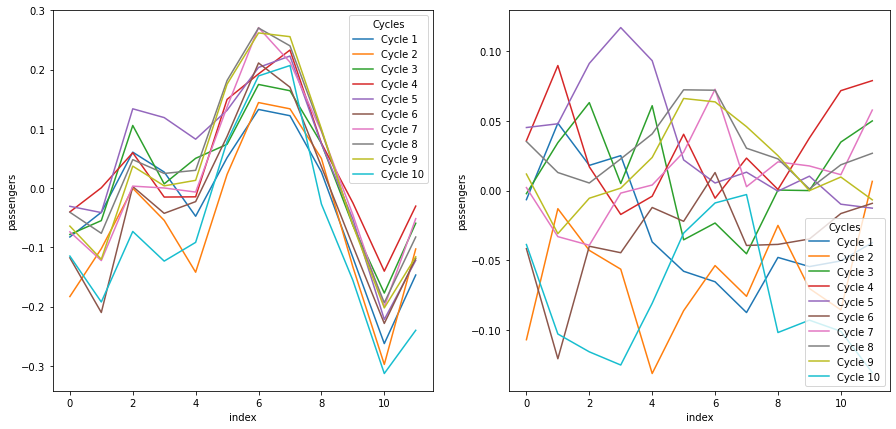

In [278]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

sns.lineplot(x='index', y='passengers', hue='Cycles', data=tr_cycle_dfm, ax=ax[0])
sns.lineplot(x='index', y='passengers', hue='Cycles', data=tr_cycle_df_clm, ax=ax[1])

plt.show()

### 1.1.d. Ruido

Una vez eliminadas la heterocedasticidad, la tendencia y la estacionalidad, lo que nos queda es el ruido. El ruido sigue una distribución normal. En este apartado debeis encontrar los parámetros de la distribución que sigue el ruido (media y desviación estandard).

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> encontrar la distribución que tiene el ruido (media y desviación estándard). Podéis usar scipy.stats. Graficar un histograma del ruido junto con un histograma de la distribución teórica que tiene el ruido.
</div>

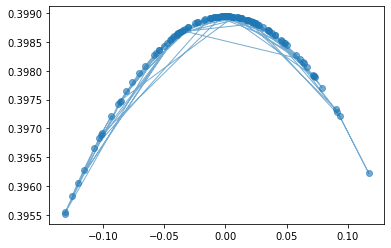

In [318]:
from scipy.stats import norm

noise_arr = tr_cycle_df_clm.passengers.array

fig, ax = plt.subplots(1, 1)
ax.plot(noise_arr, norm.pdf(noise_arr),
       'o-', lw=1, alpha=0.6, label='norm pdf')


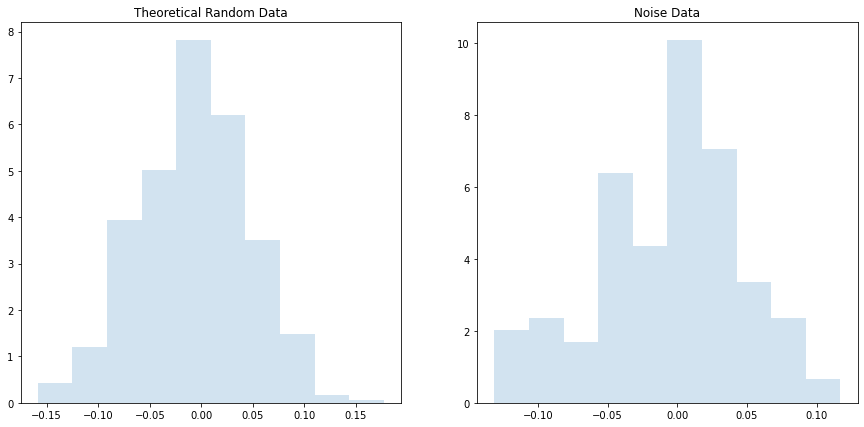

In [324]:
random_arr = norm.rvs(loc=noise_arr.mean(),scale=noise_arr.std(),size=500)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].hist(random_arr, density=True, histtype='stepfilled', alpha=0.2)
ax[0].set_title('Theoretical Random Data')
ax[1].hist(noise_arr, density=True, histtype='stepfilled', alpha=0.2)
ax[1].set_title('Noise Data')

plt.show()

## 1.2. Predicción

Vamos a predecir los dos proximos años y comparar la predicción con los datos reales. Para ello seguiremos los siguientes pasos:

   - Generar ruido
   - Añadir estacionalidad
   - Añadir tendencia
   - Añadir heterocedasticidad

### 1.2.a. Ruido

Como hemos visto que el ruido se distribuye aleatoriamente siguiendo una distribución normal, vamos a generar ruido siguiendo esta distribución.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> genera dos años de datos de ruido (24 muestras) usando la distribución encontrada en el apartado 1.1.d. Podéis usar el módulo random de numpy. Grafica los resultados.
</div>

In [327]:
# array de ruido
random_noise = np.random.normal(loc=noise_arr.mean(),scale=noise_arr.std(),size=24)
random_noise[:5]

array([-0.00436255, -0.00452948,  0.02246878, -0.00681286,  0.06615736])

<AxesSubplot:>

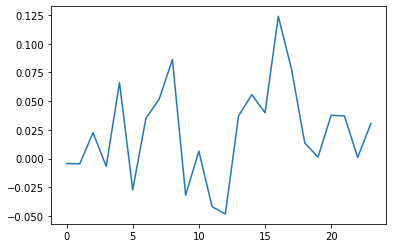

In [338]:
# es una representación de ruido aleatorio
sns.lineplot(data=random_noise)
plt.show()

### 1.2.b. Estacionalidad

Anteriormente hemos calculado la estacionalidad y el ciclo de la serie temporal. Vamos a usar esta estacionalidad ya calculada para añadirla a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido calculados en el apartado anterior los dos años de estacionalidad encontrada en el apartado 1.1.c. Grafica los resultados.
</div>

In [332]:
# llamar a la función para transformar la array en un DataFrame de ciclos

cyc_df = array_to_cycles(random_noise, 2)
cyc_df

,Cycle 1,Cycle 2
0,-0.004363,-0.048189
1,-0.004529,0.037157
2,0.022469,0.055674
3,-0.006813,0.039925
4,0.066157,0.123871
5,-0.027157,0.077828
6,0.035055,0.013666
7,0.051722,0.001234
8,0.086173,0.037739
9,-0.031821,0.037042


In [336]:
# sumo al ruido la estacionalidad

cyc_df_st = pd.DataFrame([])
cyc_df_st['Cycle 1'] = cyc_df['Cycle 1'] + tr_cycle_median[0]
cyc_df_st['Cycle 2'] = cyc_df['Cycle 2'] + tr_cycle_median[0]

cyc_df_st

,Cycle 1,Cycle 2
0,-0.080207,-0.124034
1,-0.093640,-0.051954
2,0.065174,0.098380
3,-0.004666,0.042072
4,0.055629,0.113342
5,0.082286,0.187271
6,0.233389,0.212000
7,0.261551,0.211064
8,0.161312,0.112877
9,-0.094226,-0.025363


In [345]:
cyc_df_stm = cyc_df_st.reset_index().rename(columns={'index':'month'}).melt('month', var_name='Cycles', value_name='passengers')
cyc_df_stm.head(13)

,month,Cycles,passengers
0,0,Cycle 1,-0.080207
1,1,Cycle 1,-0.093640
2,2,Cycle 1,0.065174
3,3,Cycle 1,-0.004666
4,4,Cycle 1,0.055629
5,5,Cycle 1,0.082286
6,6,Cycle 1,0.233389
7,7,Cycle 1,0.261551
8,8,Cycle 1,0.161312
9,9,Cycle 1,-0.094226


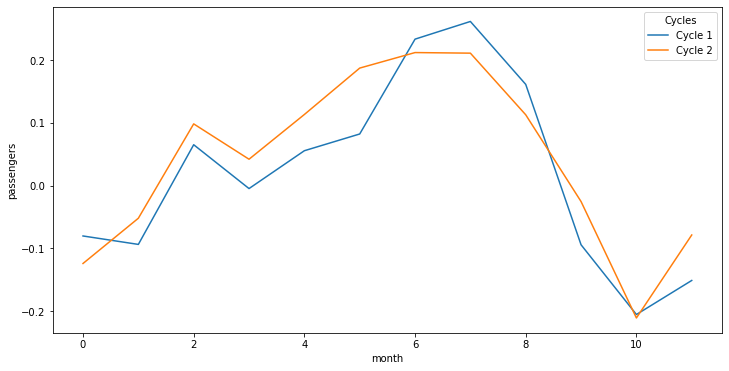

In [353]:
# al ruido añado la estacionalidad
plt.figure(figsize=(12,6))
sns.lineplot(data=cyc_df_stm, x='month', y='passengers', hue='Cycles')
plt.show()

### 1.2.c. Tendencia

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

In [359]:
cyc_df_stm['passengers'].to_numpy()

array([-0.08020688, -0.09364008,  0.0651742 , -0.00466554,  0.0556289 ,
        0.08228553,  0.23338873,  0.26155126,  0.16131198, -0.09422585,
       -0.20534948, -0.15107411, -0.12403359, -0.05195385,  0.09837982,
        0.0420723 ,  0.11334238,  0.18727066,  0.21200031,  0.21106359,
        0.11287743, -0.02536272, -0.21084691, -0.07862514])

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido + estacionalidad calculados en el apartado anterior la tendencia encontrada en el apartado 1.1.b. Grafica los resultados.
</div>

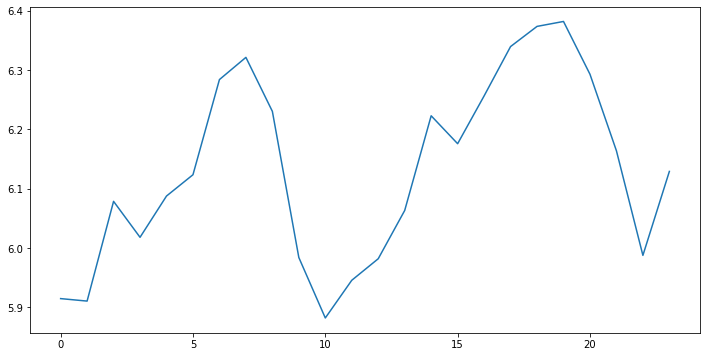

In [367]:
# añadimos la tendencia central a los datos
nst_arr = cyc_df_stm['passengers'].to_numpy() + test_tend.reshape(1,-1)[0,:]
nst_arr[:5]

# grafico los datos con tendencia
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(data=nst_arr)
plt.show()

### 1.2.d. Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido + estacionalidad + tendencia calculados en el apartado anterior la heterocedasticidad aplicando la función inversa a la encontrada en el apartado 1.1.a. Grafica el resultado junto con la serie completa y compara la predicción obtenida con los datos reales.
</div>

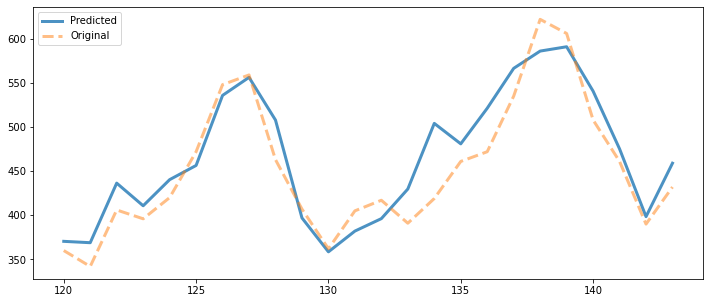

In [478]:
# aplico la función exponencial a los datos

pred_arr = np.exp(nst_arr)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x_test, pred_arr, lw=3, alpha=.8, label='Predicted')
ax.plot(x_test, test, lw=3, ls='--', alpha=.5, label='Original')
ax.legend(loc='upper left')
plt.show()

<div class="alert alert-block alert-info">
    <strong>[Bonus] Implementación:</strong> como la distribución del ruido generado es aleatoria, en cada ejecución obtendremos predicciones distintas. Una manera de asegurar que la predicción obtenida es fiable es generando intervalos de confianza. 
    <hr>
Para ello vamos a repetir los pasos anteriores pero generando 500 muestras de dos años de longitud cada una (o sea 500 predicciones). Una vez generadas definimos:
    
   - Intervalo de confianza = (min(predicciones), max(predicciones))
   - Predicción final = median(predicciones)
   
Graficar:

   - La serie temporal entera
   - Los dos años de predicción (mediana de las 500 muestras de predicción)
   - El valor real de los dos años que hemos predicho 
   - Los intérvalos de confianza (min y max de las 500 muestras de predicción) 

Para graficar los intérvalos de confianza podéis usar fill_between de matplotlib.
</div>

In [475]:
# definir una función para realizar todos los pasos

def predict_sequence(x: np.array) -> np.array:
    """Given a random array returns the predicted temporal sequence for the next 24 months."""

    cyc_df = array_to_cycles(x, 2)
    cyc_df_st = pd.DataFrame([])
    cyc_df_st['Cycle 1'] = cyc_df['Cycle 1'] + tr_cycle_median[0]
    cyc_df_st['Cycle 2'] = cyc_df['Cycle 2'] + tr_cycle_median[0]
    cyc_df_stm = cyc_df_st.reset_index().rename(columns={'index':'month'}).melt('month', var_name='Cycles', value_name='passengers')
    nst_arr = cyc_df_stm['passengers'].to_numpy() + test_tend.reshape(1,-1)[0,:]

    return np.exp(nst_arr)

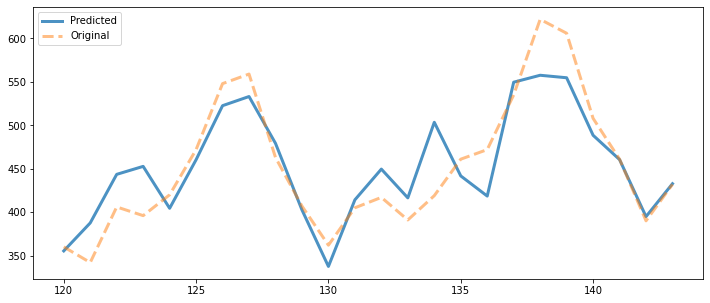

In [483]:
my_noise = np.random.normal(loc=noise_arr.mean(),scale=noise_arr.std(),size=24)

# compruebo que la función funcione
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x_test, predict_sequence(my_noise), lw=3, alpha=.8, label='Predicted')
ax.plot(x_test, test, lw=3, ls='--', alpha=.5, label='Original')
ax.legend(loc='upper left')
plt.show()

# 2. Combinación de clasificadores (5 puntos)

En este ejercicio utilizaremos un subconjunto de 5.000 imágenes provenientes del corpus EMNIST, constituido por carácteres y dígitos escritos a mano
. Dicho subconjunto está formado por 1.000 imágenes para cada una de las 5 clases diferentes ("A", "B", "C", "D" y "E").

La primera parte de este ejercicio abordará la combinación de clasificadores en paralelo mediante las tecnicas de **_Bagging_** y **_Boosting_**.

Mientras que la segunda parte pretende mejorar los resultados aplicando tecnicas de combinación secuencial de clasificadores: **_Stacking_** y **_Cascading_**.

Para empezar, vamos a visualizar el dataset. Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones. El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [409]:
with open("data_emnist.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["A", "B", "C", "D", "E"]

print("Dimensiones del vector de imágenes: {}".format(images.shape))
print("Dimensiones del vector de etiquetas: {}".format(labels.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

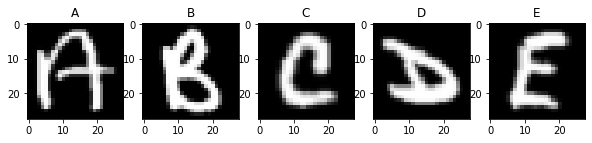

In [410]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

Para poder probar varios modelos, primero vamos a dividir el dataset en train y test.

La división con la función *train_test_split* es aleatoria , pero para que todos obtengáis los mismos resultados y poder comentar dudas por el foro, fijaremos la seed para obtener los mismos datasets de train y test. El *split* tendrá en cuenta que los dos conjuntos tengan el mismo número de ejemplos para cada una de las clases gracias al parámetro *stratify=labels*.

Como en la segunda parte de este ejercicio trataremos *stacking* y *cascading*, y ambos se aplican sobre el conjunto de test, haremos un *split* del 50% para tener un poco más de base al aplicar estas dos técnicas.

In [411]:
myseed = 13

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5,
                                                    random_state=myseed, 
                                                    stratify=labels)

## 2.1. Combinación paralela de clasificadores

### 2.1.1. Árbol de decisión

Para poder comparar el aumento de *performance* obtenido a medida que aplicamos técnicas nuevas, utilizaremos como *baseline* un simple árbol de decisión.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Evalúa la precisión de un árbol de decisión con profundidad máxima de 5 niveles (aplicaremos la misma restricción en las siguientes secciones) aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
       
<u>Sugerencia</u>: usar el módulo *cross_val_score* de *sklearn*. Para aprender más sobre *cross validation* y sobre cómo usar estos módulos, os recomendamos los siguientes enlaces: 
- http://scikit-learn.org/stable/modules/cross_validation.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

In [415]:
dtc = DecisionTreeClassifier(max_depth=5)
sc = cross_val_score(dtc, X_train, y_train, cv=5)

sc.mean(), sc.std()


(0.7944, 0.01961224107541001)

In [419]:
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)


accuracy_score(y_test, y_pred)

0.7944

### 2.1.2. *Bagging*

#### 2.1.2.a. Random Forest

La idea básica del bagging es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo Random Forest, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (el Random Forest) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
        
Evalúa la precisión de un <i>random forest</i> combinando 20 árboles de decisión con profundidad máxima de 5 niveles aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

In [422]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=5)
sc = cross_val_score(rfc, X_train, y_train, cv=5)

sc.mean(), sc.std()

(0.8864000000000001, 0.012862348152650832)

In [423]:
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

accuracy_score(y_test, y_pred)

0.8928

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

El modelo mejora los resultados. Random forest es un método de ensamblaje de árboles de decisión mediante el uso de bagging. Este algoritmo logra mejorar los resultados de un árbol de decisión porque ensambla un conjunto de árboles de decisión que han sido creados usando un conjunto de entrenamiento distinto y aleatorio (Gironés-Roig et al, 2017). 

Es de esperar que estos modelos mejoren la precisión respecto a un árbol de decisión porque al haber muchos árboles de decisión distintos, se aumenta la diversidad del model de Random Forest respecto al árbol de decisión. Esto se traduce en que este modelo tiene menos sesgo y una varianza más pequeño, lo que suele generar un modelo con un mejor rendimiento (Géron, 2019).

#### 2.1.2.b. Out-of-bag

Una ventaja del *bagging* usado en el *Random Forest* es que cada uno de los árboles de decisión ha sido entrenado con una combinación diferente de los datos (muestreo con reemplazo), es decir, cada uno de los árboles no ha visto una determinada parte de los datos originales. Esto define una especie de conjunto de test para cada uno de los árboles, llamado *out-of-bag*, que puede ser usado para estimar el error del modelo sin necesidad de usar el conjunto de test real que creamos previamente, ni de usar estrategias de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
      
Entrena sobre el conjunto de train un modelo de <i>random forest</i>combinando 20 árboles de decisión con profundidad máxima de 5 niveles y muestra la precisión de este modelo en el *out-of-bag*.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender más sobre *out-of-bag* y sobre como usar este módulo (incluyendo el atributo *oob&#95;score_*), os recomendamos los siguientes enlaces:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

</div>

In [428]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=5, oob_score=True)

rfc.fit(X_train, y_train)

rfc.oob_score_

0.8504

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿la precisión obtenida en el <i>out-of-bag</i> y con los métodos de validación anteriores son comparables? ¿Era de esperar? 
</div>

Sí, porque en el out-of-bag se utiliza para validar el modelo las instancias no utilizadas durante el entrenamiento.

Más en concreto, para cada árbol entrenado se genera un conjunto de entrenamiento aleatorio. Del conjunto de entrenamiento, se seleccionan unas instancias y otras no son seleccionadas. Estas instancias son las que están out-of-bag. De manera que se pueden emplear para validar este modelo, dado que son instancias que no se han usado para entrenar el modelo. En el siguiente árbol, se generarán otras instancias de entrenamiento y las instancias out-of-bag serán distintas, de manera que los diferentes árboles de decisión se estarán validando (y entrenando) con instancias distintas. 

Estas instancias quedan fuera porque el training set se generá mediante reemplazo. Es decir, en cada uno de estos trainning sets habrá algunos instancias que se repetirán y por lo tanto, algunas quedarán out-of-bag.

#### 2.1.2.c. Número de clasificadores agregados

En los ejercicios anteriores hemos combinado 20 clasificadores simples en nuestro clasificador combinado. ¿Será que la precisión del clasificador combinado aumenta indefinidamente su desempeño si añadimos más clasificadores?

Para responder a esta pregunta vamos a representar una curva de validación. La curva de validación es una representación gráfica del desempeño de un modelo variando uno de sus parámetros. Esto nos permite entender cuál es el impacto de un determinado parámetro en el desempeño de un modelo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>    
    
Entrena varios modelos de <it>Random Forest</it> con un número de árboles cada vez mayor. Para cada modelo, calcula su precisón en el conjunto de test o usando *cross-validation* en el conjunto de entrenamiento. Opcional: representa gráficamente la evolución de la precisión con el número de árboles para ayudarte en el análisis de los resultados.
<br><br>
    
<u>Sugerencia</u>: usar el módulo *validation_curve* de sklearn. Para aprender a usar este módulo os recomendamos los siguientes enlaces:<br>
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
- http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

In [434]:
np.linspace(4, 200, 50, dtype=int)


array([  4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,  52,
        56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104,
       108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156,
       160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200])

In [436]:
estimators = np.linspace(4, 200, 50, dtype=int)
score = []
for estimator in estimators:
    rfc = RandomForestClassifier(n_estimators=estimator, max_depth=5)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    score.append(accuracy_score(y_test, y_pred))

score[:10]
    

[0.836, 0.8604, 0.8828, 0.8904, 0.8896, 0.8908, 0.892, 0.8932, 0.8888, 0.8968]

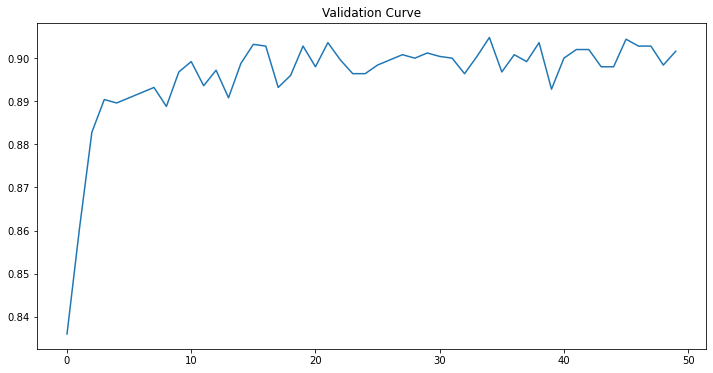

In [438]:
# grafico los datos con tendencia
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(data=score)
plt.title('Validation Curve')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿incrementa indefinidamente la precisión con el número de árboles combinados o se satura en una precisión límite? ¿Por qué?
</div>

Mirando la curva de validación se puede ver que a partir de unas veinte instancias, aumentar el número de árboles en el modelo no aumenta la precisión. Esto es así porque llega un momento donde la reducción del sesgo que a porta el nuevo árbol es casi nula. Además, una de las aportaciones del uso de random forest es que permite seleccionar variables que normalmente no se usarían porque quedarían eclipsadas por otras más relevantes (Gironés-Roig et al., 2017). Las variables que son eclipsadas son un número finito, y cuando se han generado un número suficiente de árboles de decisión para considerar todas estas variables, el modelo ya no mejora porque los árboles ya comezan a ser redundantes y a no aportar información nueva, únicamente coste computacional. 

### 2.1.3. *Boosting*

En el sistema de Boosting se combinan varios clasificadores débiles sequencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificados en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>

Evalúa la precisión de un <i>gradient boosting</i> con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i> aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *GradientBoostingClassifier* de sklearn. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

In [464]:
gbc = GradientBoostingClassifier(max_depth=5, n_estimators=20)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

accuracy_score(y_test, y_pred)

0.9196

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

Los algoritmos de boosting como Ada Bost se basan en generar modelos de forma secuencial. De manera que los modelos más nuevos van resolviendo las carencias de los modelos anteriores. En este caso, se reduce el sesgo de los modelos iniciales generando modelos nuevos que son más sensibles a los datos en los que los modelos anteriores habían fallado. De manera que en la segunda etapa de boosting se genera un nuevo train set en las que las instancias que habían sido erradas por el primer modelo tienen más peso (Gironés-Roig et al., 2017). Este proceso se repite, de manera que los diferentes árboles reducen los errores cometidos por los modelos anteriores. Y es de esperar que en este método tenga un mejor rendimiento que un árbol de decisión simple.

## 2.2. Combinación secuencial de clasificadores base diferentes

Para poder hacer combinación secuencial de modelos, necessitamos tener varios modelos diferentes entrenados. 

En nuestro caso, ya tenemos un árbol de decisión, el *random forest* y el *gradient boosting*. Vamos a entrenar un par de modelos más.

### 2.2.1 Clasificadores adicionales

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Entrena un <i>k-neighbors</i> con 2 vecinos sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 

Entrena un SVM (Suport vector machines) con gamma = 0.07 sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 
</div>  

In [446]:
# K-Near Neighbors Classifier
knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

print("KNN Score:", accuracy_score(y_test, y_pred))

# Suport Vector Machines Classifier
svmc = SVC(gamma=0.07)
svmc.fit(X_train, y_train)
y_pred = svmc.predict(X_test)

print("SVM Score:", accuracy_score(y_test, y_pred))

KNN Score: 0.9212
SVM Score: 0.2


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> comenta los resultados.
</div>

En este caso, tenemos que el algoritmo de KNN tiene un buen rendimiento. Con una precisión superior al 90%. En cambio, el algoritmo de SVM tiene una capacidad predictiva más baja y clasifica correctamente el 20% de las instancias. 

EL rendimiento del primer modelo es mayor que el del segundo modelo.

### 2.2.2 *Stacking*

Un clasificador de *stacking* usa como atributos las predicciones hechas por otros clasificadores en lugar de los datos originales de entrada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>stacking</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones hechas en el conjunto de test por los algoritmos: 
    
- árbol de decisión
- random forest
- gradient boosting
- knn
- svm 
 
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test (en este caso no tenemos conjunto de train, con lo cual se hace directamente cross-validation sobre test).

<u>Sugerencia</u>: usar la función column_stack de numpy para juntar todas las predicciones. Dado que las variables que usaremos ahora como predictors son categóricas, es preferible transformarlas en *dummies* (*one-hot-encoding*). Para apender a usar estas funciones os recomendamos los siguientes enlaces:
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
</div>

In [449]:
dtc_pred = dtc.predict(X_test)
rfc_pred = rfc.predict(X_test)
gbc_pred = gbc.predict(X_test)
knc_pred = knc.predict(X_test)
svmc_pred = svmc.predict(X_test)

models_stack = np.column_stack((dtc_pred, rfc_pred, gbc_pred, knc_pred, svmc_pred))

In [454]:
models_stack[:7,:]

array([[1, 2, 2, 2, 4],
       [0, 0, 0, 0, 4],
       [2, 2, 2, 2, 4],
       [2, 2, 2, 2, 4],
       [2, 2, 2, 2, 4],
       [2, 2, 2, 2, 4],
       [2, 2, 2, 2, 4]], dtype=uint8)

In [456]:
models_df = pd.DataFrame(models_stack, columns=['dtc_pred', 'rfc_pred', 
                                                'gbc_pred', 'knc_pred', 'svmc_pred'])

models_df.head()

,dtc_pred,rfc_pred,gbc_pred,knc_pred,svmc_pred
0,1,2,2,2,4
1,0,0,0,0,4
2,2,2,2,2,4
3,2,2,2,2,4
4,2,2,2,2,4


In [459]:
models_dummies = pd.get_dummies(models_df.astype('str'))
models_dummies.head()

,dtc_pred_0,dtc_pred_1,dtc_pred_2,dtc_pred_3,dtc_pred_4,rfc_pred_0,rfc_pred_1,rfc_pred_2,rfc_pred_3,rfc_pred_4,...,gbc_pred_1,gbc_pred_2,gbc_pred_3,gbc_pred_4,knc_pred_0,knc_pred_1,knc_pred_2,knc_pred_3,knc_pred_4,svmc_pred_4
0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


In [465]:
gbc = GradientBoostingClassifier(max_depth=5, n_estimators=20)

sc = cross_val_score(gbc, models_dummies, y_test, cv=5)

sc.mean(), sc.std()

(0.9311999999999999, 0.008059776671843925)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>stacking</i>? Comenta los resultados.
</div>

El valor de entrada del algoritmo de ensamblaje son las predicciones de los modelos originales. Era de esperar que el modelo mejorará la predición de los modelos originales porque utiliza y combina las diferentes predicciones de los modelos originales. De manera que el algoritmo se entrena sobre las predicciones de los algoritmos anteriores. Esto genera que el algoritmo de stacking mejore sus predicciones respecto a los algoritmos anteriores.

Como se puede ver, el algoritmo tiene un 93% de predicción que es mayor que la predicción de cualquiera de los algoritmos que se usan como outputs. Además, la desviación estándar del modelo es muy baja, por lo que el rendimiento del modelo se ha mostrado muy consisitente en la validación cruzda.

### 2.2.3. *Cascading*

El caso de *cascading* es parecido al de *stacking* pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>cascading</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones obtenidas con los modelos anteriores en el conjunto de test (igual que con el <i>stacking</i>), y también las variables originales. 
    
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test.

<u>Sugerencia</u>: Usa el mismo conjunto de datos que en el ejercicio anterior pero añade `X_test`.
</div>

In [469]:
X_train.shape, models_stack.shape

((2500, 784), (2500, 5))

In [470]:
X_train_df = pd.DataFrame(X_train)
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [472]:
models_and_data_df = pd.concat([models_dummies, X_train_df], axis=1)
models_and_data_df.head()

,dtc_pred_0,dtc_pred_1,dtc_pred_2,dtc_pred_3,dtc_pred_4,rfc_pred_0,rfc_pred_1,rfc_pred_2,rfc_pred_3,rfc_pred_4,...,774,775,776,777,778,779,780,781,782,783
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [473]:
gbc = GradientBoostingClassifier(max_depth=5, n_estimators=20)

sc = cross_val_score(gbc, models_and_data_df, y_test, cv=5)

sc.mean(), sc.std()

(0.9259999999999999, 0.009879271228182749)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>cascading</i>? Comenta los resultados.
</div>

Cascading es un modelo como el de stacking en el que se añaden los datos de entrada originales usados para entrenar los modelos. De nuevo, la combianción de estos modelos genera un rendimiento mayor que los modelos que utiliza como output. Como era de esperar, por las razones que comento en el ensamblaje de Stacking. Aún así, este modelo con más variables de entrada, no mejora el rendimiento del modelo de stacking. Probablemente, el hecho de incorporar tantos atributos de entrada genera un poco de overfitting, comparado con el modelo anterior. De manera que, en este caso particular, añadir las variables originales no está mejorando el modelo y el mejor rendimiento lo he obtenido con el modelo de stack. 